# Building Seq2Seq LSTM with Luong Attention in Keras for Time Series Forecasting

This notebook presents the application of Seq2Seq in solving time series problems. Two Models are discussed: a simple Seq2Seq LSTM Model, and a Seq2Seq LSTM Model with Luong Attention.

Source: The original tutorial can be found [here](https://levelup.gitconnected.com/building-seq2seq-lstm-with-luong-attention-in-keras-for-time-series-forecasting-1ee00958decb).

## Import Packages

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt

import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

## Simulate Data

We’ve just created two sequences, x1 and x2, by combining sin waves, trend, and random noise.


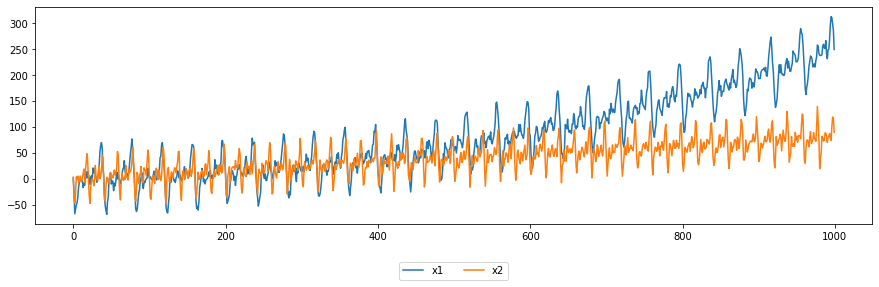

In [2]:
n_ = 1000
t = np.linspace(0, 50*np.pi, n_)
# pattern + trend + noise
x1 = sum([20*np.sin(i*t+np.pi) for i in range(5)]) + 0.01*(t**2) + np.random.normal(0, 6, n_)
x2 = sum([15*np.sin(2*i*t+np.pi) for i in range(5)]) + 0.5*t + np.random.normal(0, 6, n_)
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x2)), x2, label='x2')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Data Preprocessing

First, we split train and test data.

In [3]:
train_ratio = 0.8
train_len = int(train_ratio * t.shape[0])
print(train_len)

800


Next, we detrend the data:

It is not a must to detrend time series. However stationary time series will make model training much easier. There are many ways to detrend time series, such as taking difference of sequence with its lag1. Here for the simplicity, we assume the order of trend is known and we are just going to simply fit separate trend lines to x1 and x2, and then subtract the trend from the corresponding original sequence.

We will create index number of each position in the sequence, for easier detrending and trend recover.

In [5]:
x_index = np.array(range(len(t)))

x1_trend_param = np.polyfit(x_index[:train_len], x1[:train_len], 2)
x2_trend_param = np.polyfit(x_index[:train_len], x2[:train_len], 1)
print(x1_trend_param)
print(x2_trend_param)

[ 2.49846107e-04  3.40300744e-03 -1.60591438e+00]
[ 0.08116842 -0.93924559]


Based on the above values we got, we can now come up with the trend lines for x1 and x2.

In [6]:
x1_trend = (x_index**2)*x1_trend_param[0]+x_index*x1_trend_param[1]+x1_trend_param[2]
x2_trend = x_index*x2_trend_param[0]+x2_trend_param[1]

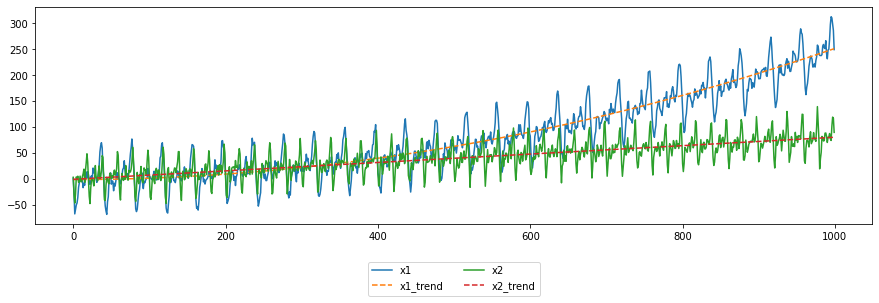

In [8]:
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1)), x1, label='x1')
plt.plot(range(len(x1_trend)), x1_trend, linestyle='--', label='x1_trend')
plt.plot(range(len(x2)), x2, label='x2')
plt.plot(range(len(x2_trend)), x2_trend, linestyle='--', label='x2_trend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

The above result looks fine, now we can deduct the trend.

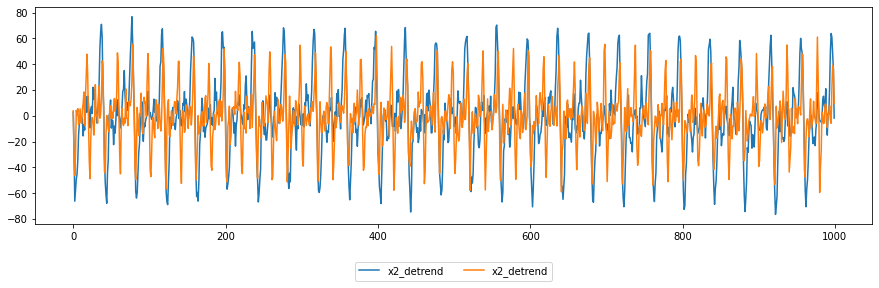

In [9]:
x1_detrend = x1 - x1_trend
x2_detrend = x2 - x2_trend
plt.figure(figsize=(15, 4))
plt.plot(range(len(x1_detrend)), x1_detrend, label='x2_detrend')
plt.plot(range(len(x2_detrend)), x2_detrend, label='x2_detrend')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

For easier preprocessing in next several steps, we can combine the sequences and their relevant information together into one array.

In the combined array we created x_lbl:
- the first column is the detrended x1
- the second column is the detrended x2
- the third column is the index
- the fourth column is the label (1 for train set and 0 for test set)

In [10]:
x_lbl = np.column_stack([x1_detrend, x2_detrend, x_index, [1]*train_len+[0]*(len(x_index)-train_len)])
print(x_lbl.shape)
print(x_lbl)

(1000, 4)
[[  2.84824852   3.8775824    0.           1.        ]
 [-25.41323379 -29.47067479   1.           1.        ]
 [-66.15290667 -46.16602436   2.           1.        ]
 ...
 [ 47.8085187   39.05691789 997.           0.        ]
 [ 35.82517833  36.66018449 998.           0.        ]
 [ -1.76791467   9.48784984 999.           0.        ]]


Normalisation can help model avoid favouring large features while ignoring very small features. Here we can just simply normalise x1 and x2 by dividing the corresponding maximum values in train set.


In [11]:
x_train_max = x_lbl[x_lbl[:, 3]==1, :2].max(axis=0)
x_train_max = x_train_max.tolist()+[1]*2  # only normalize for the first 2 columns
print(x_train_max)

[76.73820738953664, 62.027197994968574, 1, 1]


In [12]:
x_normalize = np.divide(x_lbl, x_train_max)
print(x_normalize)

[[ 3.71164328e-02  6.25142280e-02  0.00000000e+00  1.00000000e+00]
 [-3.31167937e-01 -4.75125038e-01  1.00000000e+00  1.00000000e+00]
 [-8.62059578e-01 -7.44286794e-01  2.00000000e+00  1.00000000e+00]
 ...
 [ 6.23008021e-01  6.29674065e-01  9.97000000e+02  0.00000000e+00]
 [ 4.66849299e-01  5.91034025e-01  9.98000000e+02  0.00000000e+00]
 [-2.30382587e-02  1.52962735e-01  9.99000000e+02  0.00000000e+00]]


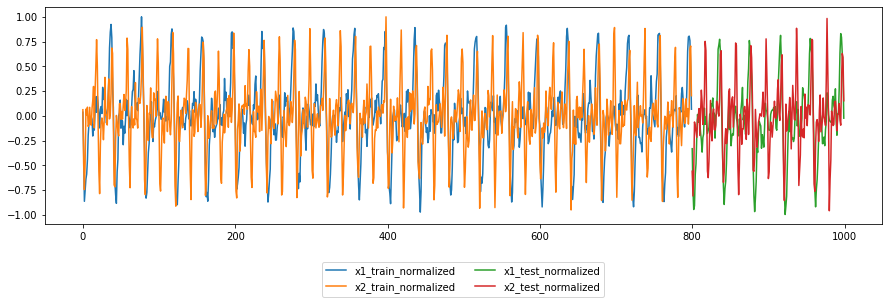

In [13]:
plt.figure(figsize=(15, 4))
plt.plot(range(train_len), x_normalize[:train_len, 0], label='x1_train_normalized')
plt.plot(range(train_len), x_normalize[:train_len, 1], label='x2_train_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 0], label='x1_test_normalized')
plt.plot(range(train_len, len(x_normalize)), x_normalize[train_len:, 1], label='x2_test_normalized')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Next, we will cut sequence into smaller pieces by sliding an input window (length = 200 time steps) and an output window (length = 20 time steps), and put these samples in 3d numpy arrays.

In [15]:
def truncate(x, feature_cols=range(3), target_cols=range(3), label_col=3, train_len=100, test_len=20):
    in_, out_, lbl = [], [], []
    for i in range(len(x)-train_len-test_len+1):
        in_.append(x[i:(i+train_len), feature_cols].tolist())
        out_.append(x[(i+train_len):(i+train_len+test_len), target_cols].tolist())
        lbl.append(x[i+train_len, label_col])
    return np.array(in_), np.array(out_), np.array(lbl)
X_in, X_out, lbl = truncate(x_normalize, feature_cols=range(3), target_cols=range(3), 
                            label_col=3, train_len=200, test_len=20)
print(X_in.shape, X_out.shape, lbl.shape)

(781, 200, 3) (781, 20, 3) (781,)


In [16]:
X_input_train = X_in[np.where(lbl==1)]
X_output_train = X_out[np.where(lbl==1)]
X_input_test = X_in[np.where(lbl==0)]
X_output_test = X_out[np.where(lbl==0)]
print(X_input_train.shape, X_output_train.shape)
print(X_input_test.shape, X_output_test.shape)

(600, 200, 3) (600, 20, 3)
(181, 200, 3) (181, 20, 3)


Now the data is ready to be input into neural network!

## Model 1: Simple Seq2Seq LSTM Model

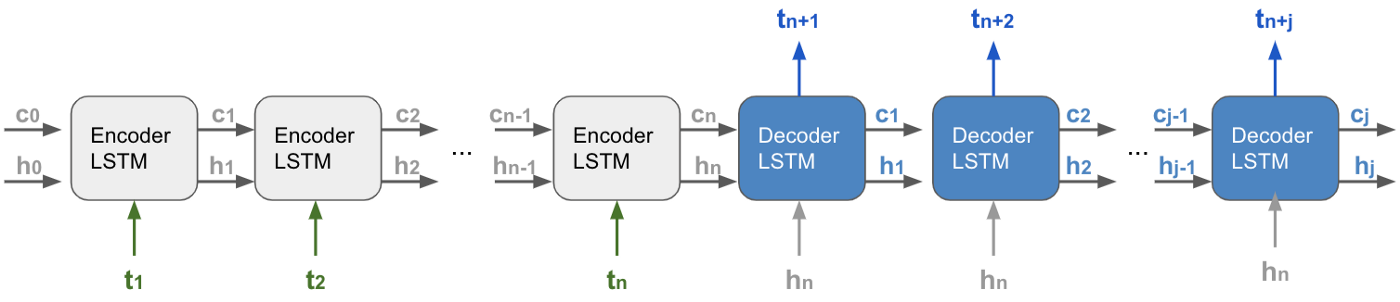

The above figure represents unfolded single layer of Seq2Seq LSTM model:

- **The encoder LSTM cell**: The value of each time step is input into the encoder LSTM cell together with previous cell state c and hidden state h, the process repeats until the last cell state c and hidden state h are generated.

- **The decoder LSTM cell**: We use the last cell state c and hidden state h from the encoder as the initial states of the decoder LSTM cell. The last hidden state of encoder is also copied 20 times, and each copy is input into the decoder LSTM cell together with previous cell state c and hidden state h. The decoder outputs hidden state for all the 20 time steps, and these hidden states are connected to a dense layer to output the final result.

Set the number of hidden layers.

In [17]:
n_hidden = 100

The input layer:

In [18]:
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 2), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


The encoder LSTM: 

In [19]:
# for simple Seq2Seq model, we only need last state_h and last state_c
encoder_last_h1, encoder_last_h2, encoder_last_c = LSTM(
 n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
 return_sequences=False, return_state=True)(input_train)
print(encoder_last_h1)
print(encoder_last_h2)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/strided_slice_3:0', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:4', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm/while:5', description="created by layer 'lstm'")


Batch normalisation is added because we want to avoid gradient explosion caused by the activation function ELU in the encoder.

In [20]:
encoder_last_h1 = BatchNormalization(momentum=0.6)(encoder_last_h1)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

Next, we make 20 copies of the last hidden state of encoder and use them as input to the decoder. The last cell state and the last hidden state of the encoder are also used as the initial states of decoder.


In [21]:
decoder = RepeatVector(output_train.shape[1])(encoder_last_h1)
decoder = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, return_state=False, return_sequences=True)(
    decoder, initial_state=[encoder_last_h1, encoder_last_c])
print(decoder)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_1/transpose_1:0', description="created by layer 'lstm_1'")


In [22]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed/Reshape_1:0', description="created by layer 'time_distributed'")


Then we put everything into the model, and compile it. Here we simply use MSE as the loss function and MAE as the evaluation metric. Note that we set clipnorm=1 for Adam optimiser. This is to normalise the gradient, so as to avoid gradient explosion during back propagation.


In [23]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100)          400         lstm[0][0]                       
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 20, 100)      0           batch_normalization[0][0]        
______________________________________________________________________________________________

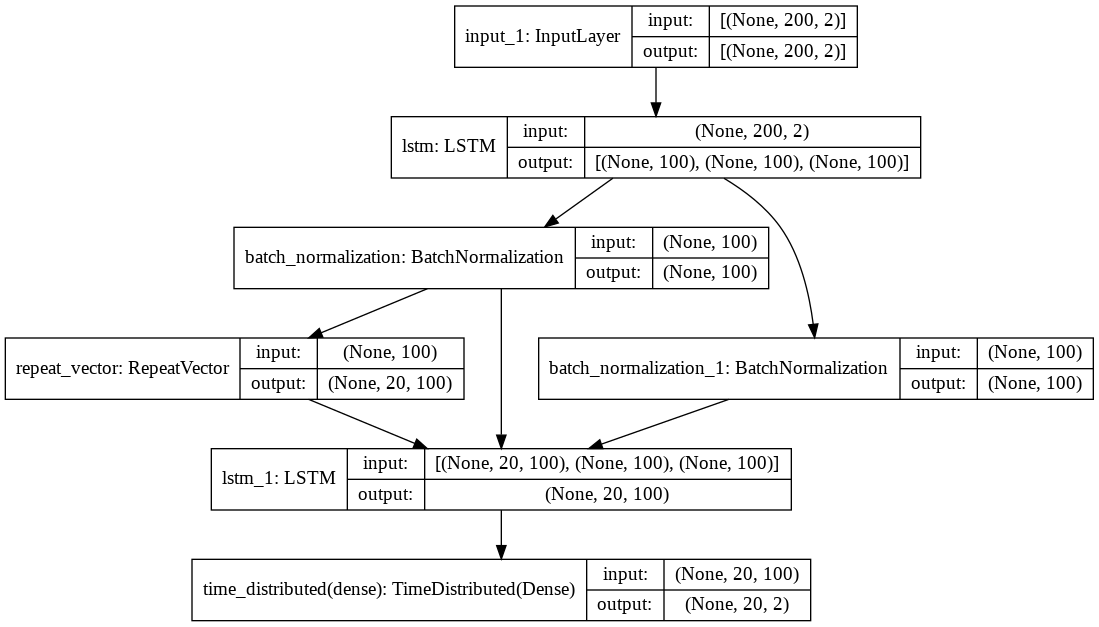

In [24]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

Next, we train the model with 100 epochs.

In [25]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq.h5')

Epoch 1/100
5/5 [==============================] - 9s 744ms/step - loss: 7.2836 - mae: 1.1872 - val_loss: 0.1506 - val_mae: 0.2924
Epoch 2/100
5/5 [==============================] - 3s 667ms/step - loss: 0.2037 - mae: 0.3503 - val_loss: 0.1256 - val_mae: 0.2575
Epoch 3/100
5/5 [==============================] - 3s 557ms/step - loss: 0.1318 - mae: 0.2749 - val_loss: 0.1229 - val_mae: 0.2565
Epoch 4/100
5/5 [==============================] - 3s 543ms/step - loss: 0.1232 - mae: 0.2625 - val_loss: 0.1193 - val_mae: 0.2518
Epoch 5/100
5/5 [==============================] - 3s 549ms/step - loss: 0.1181 - mae: 0.2553 - val_loss: 0.1102 - val_mae: 0.2409
Epoch 6/100
5/5 [==============================] - 3s 532ms/step - loss: 0.1101 - mae: 0.2447 - val_loss: 0.1033 - val_mae: 0.2345
Epoch 7/100
5/5 [==============================] - 3s 529ms/step - loss: 0.1070 - mae: 0.2420 - val_loss: 0.1018 - val_mae: 0.2354
Epoch 8/100
5/5 [==============================] - 3s 532ms/step - loss: 0.0990 - m

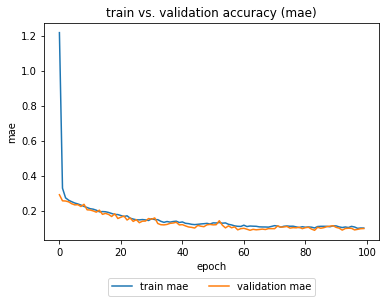

In [26]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

Prediction:

In [27]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


Then we combine the unnormalised outputs with their corresponding index, so that we can recover the trend.

In [28]:
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)
train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


Next, we put all the outputs with recovered trend into a dictionary data_final.

In [29]:
data_final = dict()
for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))

train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


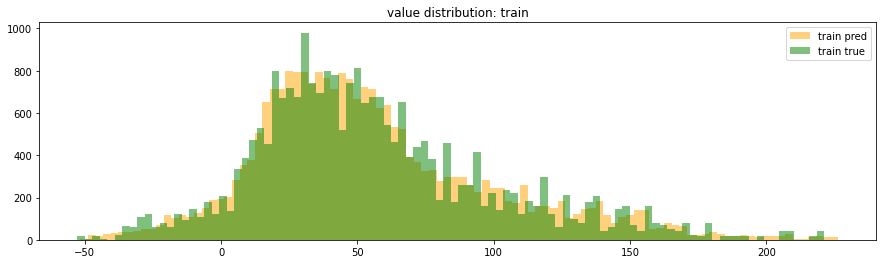

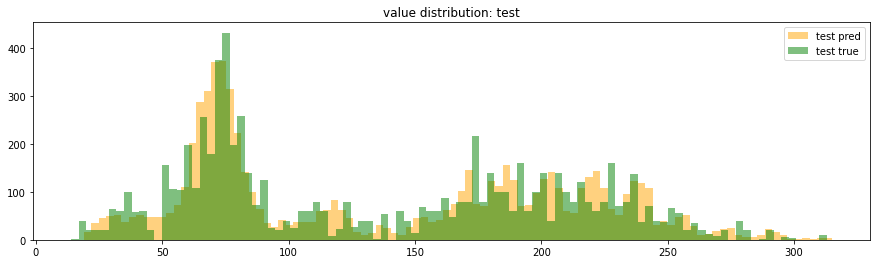

In [30]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

The data distribution of prediction and true values are almost overlapped, so we are good.

We can also plot MAE of all samples in time order, to see if there is clear pattern. The ideal situation is when line is random, otherwise it may indicate that the model is not sufficiently trained.

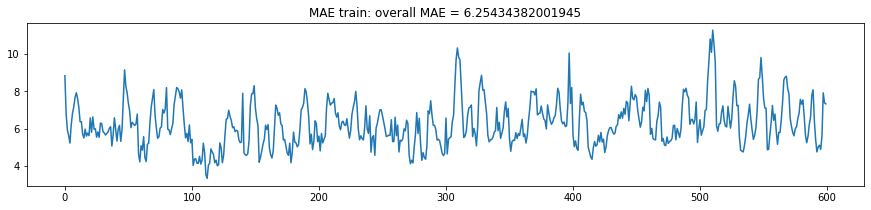

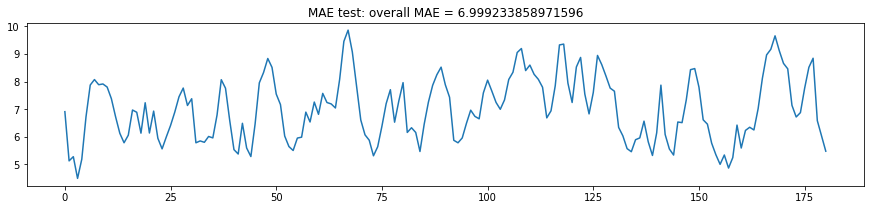

In [31]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show()

Based on the above plots, we can say that there are still certain periodical pattens in both train and test MAE. Training for more epochs may lead to better results.

Next we are going to check some random samples and see if the predicted lines and corresponding true lines are aligned.


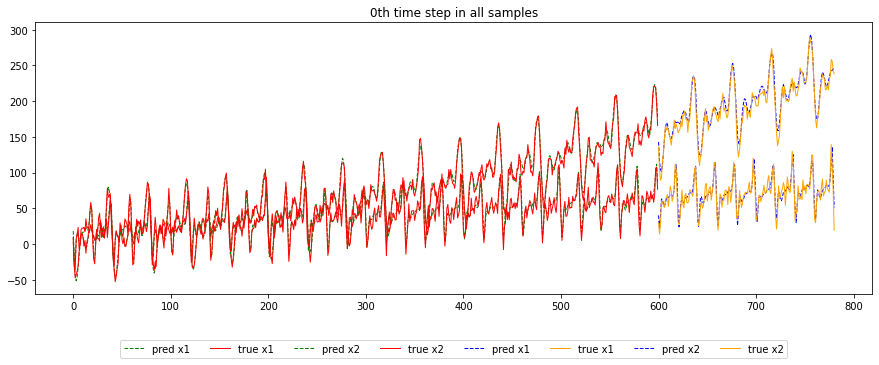

In [32]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

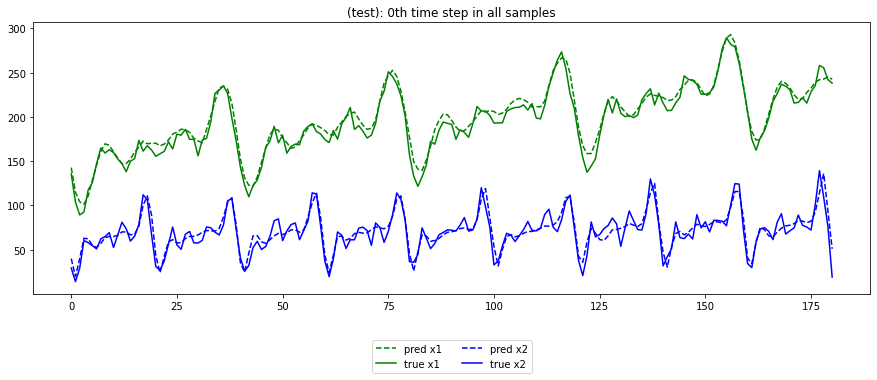

In [33]:
lb = 'test'
plt.figure(figsize=(15, 5))
for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
    plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
    plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

## Model 2: Seq2Seq LSTM Model with Luong Attention

One of the limitations of simple Seq2Seq model is: only the last state of encoder RNN is used as input to decoder RNN. If the sequence is very long, the encoder will tend to have much weaker memory about earlier time steps. Attention mechanism can solve this problem. An attention layer is going to assign proper weight to each hidden state output from encoder, and map them to output sequence.

Next we will build Luong Attention on top of Model 1, and use Dot method to calculate alignment score.

Input layer (same as Model 1):

In [34]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

The encoder LSTM:

This is slightly different from Model 1: besides returning the last hidden state and the last cell state, we also need to return the stacked hidden states for alignment score calculation.

In [35]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

KerasTensor(type_spec=TensorSpec(shape=(None, 200, 100), dtype=tf.float32, name=None), name='lstm_2/transpose_1:0', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:4', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 100), dtype=tf.float32, name=None), name='lstm_2/while:5', description="created by layer 'lstm_2'")


Next, we apply batch normalisation to avoid gradient explosion.

In [36]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h)
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c)

The Decoder LSTM:

Next, we repeat the last hidden state of encoder 20 times, and use them as input to decoder LSTM.

In [37]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


We also need to get the stacked hidden state of de decoder for alignment score calculation.

In [38]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='lstm_3/transpose_1:0', description="created by layer 'lstm_3'")


Attention Layer:

To build the attention layer, the first thing to do is to calculate the alignment score, and apply softmax activation function over it:

In [39]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='activation/truediv:0', description="created by layer 'activation'")


Then we can calculate the context vector, and also apply batch normalisation on top of it:

In [41]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 100), dtype=tf.float32, name=None), name='batch_normalization_4/batchnorm/add_1:0', description="created by layer 'batch_normalization_4'")


Now we concat the context vector and stacked hidden states of decoder, and use it as input to the last dense layer.

In [42]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 200), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [43]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 20, 2), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


Then we can compile the model. The parameters are the same as those in Model 1, for the sake of comparing the performance of the 2 models.

In [44]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200, 2)]     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 200, 100), ( 41200       input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 100)          400         lstm_2[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_2[0][0]      
____________________________________________________________________________________________

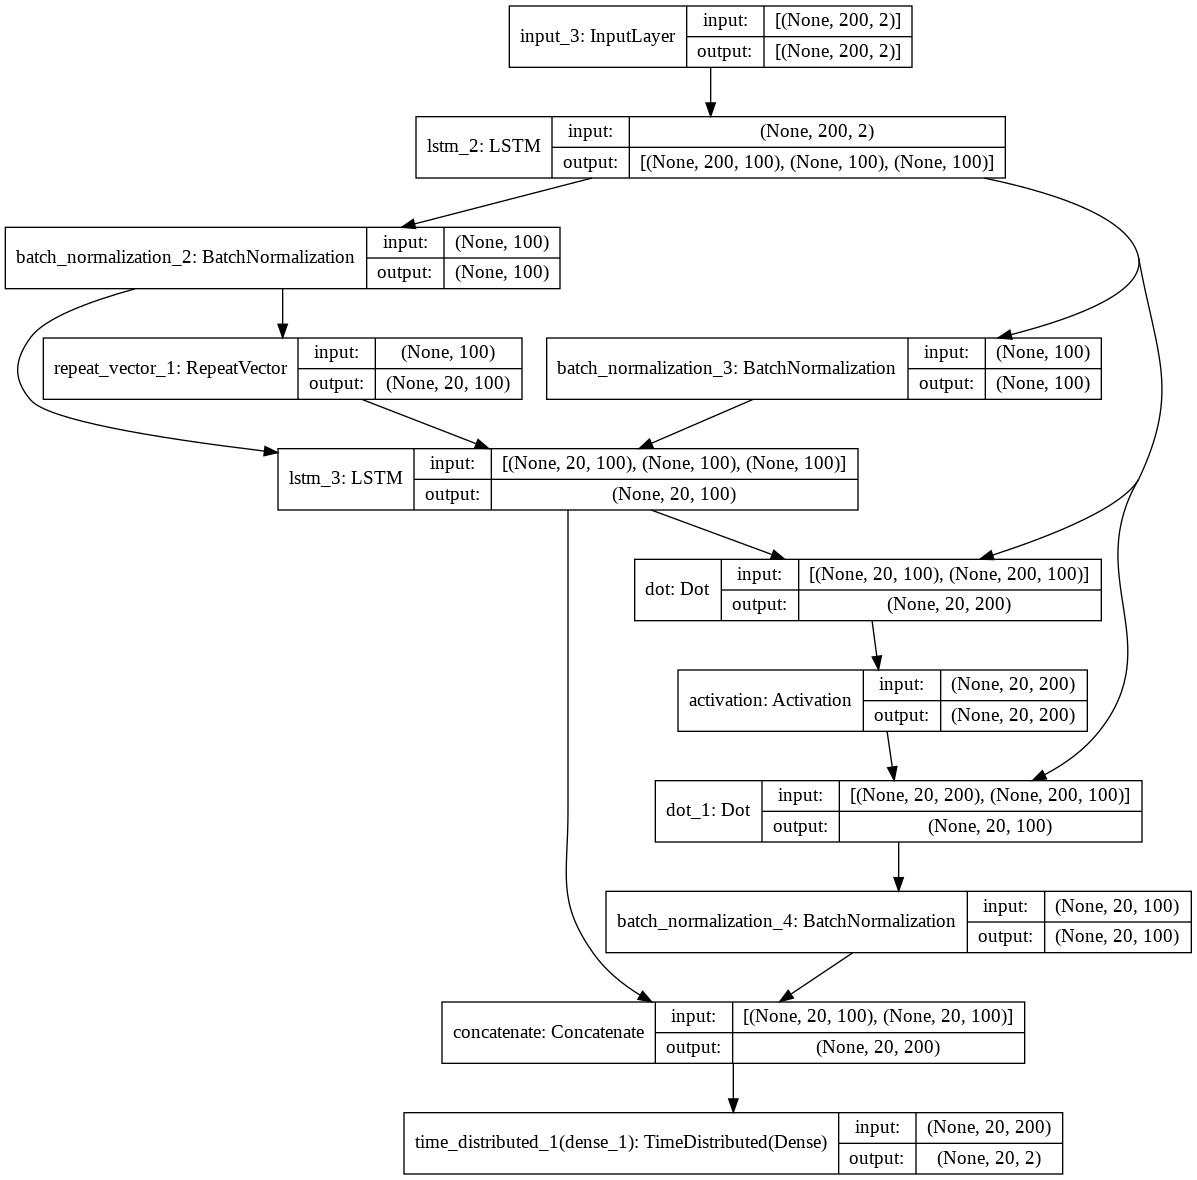

In [45]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

We will also train this model for 100 epoches.

In [ ]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
model.save('model_forecasting_seq2seq_att.h5')

In [ ]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()